In [ ]:
#!unzip "/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision"

# Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow and TensorFlow Hub. 

By following the worklow:

1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, 3 sets, X & y).
3. Choose and fit/train a model (TensorFlow Hub, tf.keras.applications, TensorBoard, EarlyStopping).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works and then increase it).
6. Save, sharing and reloading the model.

## Getting the workspace ready

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

#Check for GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.4.1
Hub version: 0.11.0
GPU not available


## Getting the data ready (turning into Tensors)

In [2]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     ee307ebe9e98bac8b8a47be0d4803ba1  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


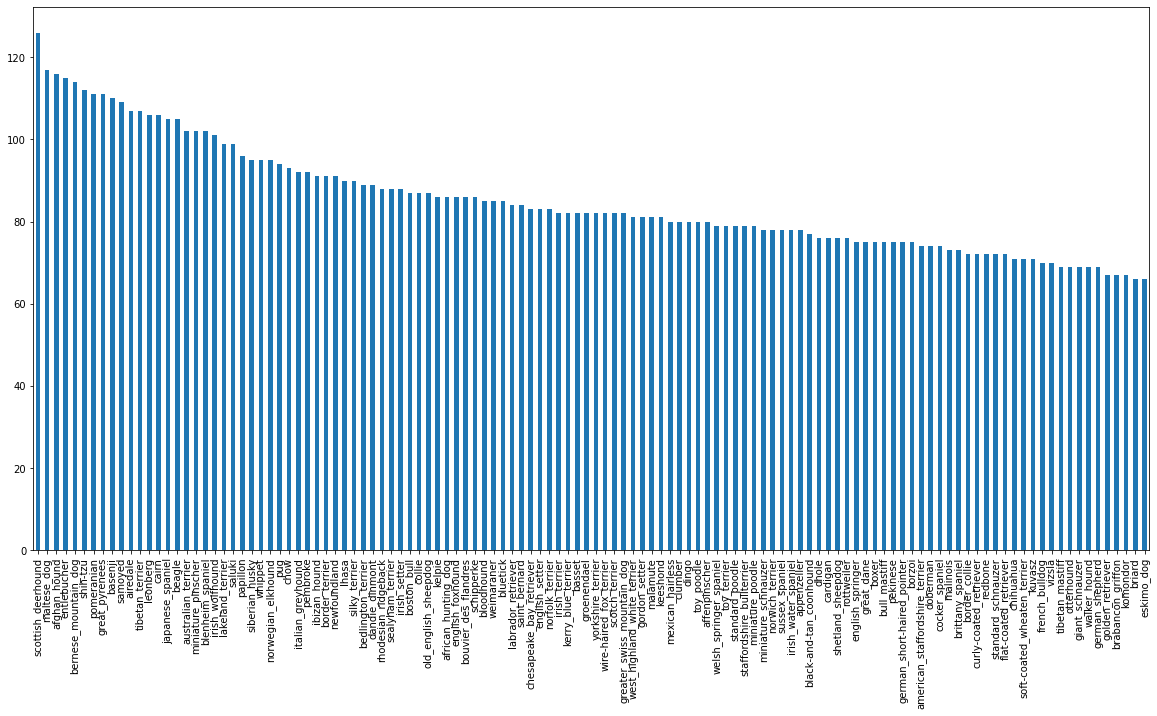

In [6]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [7]:
labels_csv["breed"].value_counts().median()

82.0

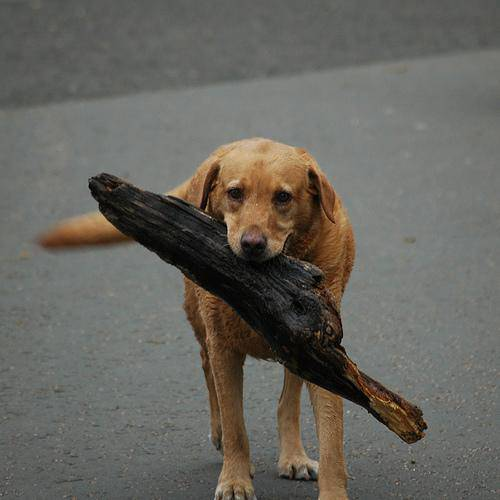

In [8]:
# View an image
from IPython.display import Image
Image("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Listing all the images file pathnames.

In [13]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 

In [14]:
import os
os.listdir("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/")[:10]

['e073b458a33cbfe9b733764a1246f52e.jpg',
 'e79a5176fe0322a36d09f057d64aec54.jpg',
 'dd5a3c84fb3c388ecf0b4da61eaef352.jpg',
 'deb88665ad11440ea55963b57e9ad79c.jpg',
 'e2379f60b78b0939a84ebd641ff3bb4a.jpg',
 'df464ebe3f311744241cb3d9258a5000.jpg',
 'dee5db7f0834ca1db80615a9d5fb6334.jpg',
 'e47a26a0b4510b25250f654577207ed3.jpg',
 'dd126e42b474c3831f8fda33052428c1.jpg',
 'e0c2b69fc53eeb74dfbf31a1ce54b11a.jpg']

In [15]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Documentos/Machine Learning/Doogo Vision/train/")) == len(filenames):
  print("Filenames match")
else:
  print("Filenames do not match")

Filenames match


In [16]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [17]:
len(labels)

10222

In [18]:
# Check if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("match")
else:
  print("Do not match")

match


In [20]:
# Find the unique label values and turn it to numbers
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [21]:
# Turn a label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

### Creating own validation set

Kaggle does not provide one for this Data